In [1]:
# pacotes básicos
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.tree import plot_tree, export_graphviz, export_text
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
#pacotes para apoio a leitura e gravação de datasets
from pathlib import Path
import csv
import pprint
# para silenciar warnings
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import os

In [2]:
DATA_PATH = './Dados'

In [144]:
''' Juntar todos os datasets '''
treino = pd.DataFrame()
teste = pd.DataFrame()
for filename in os.listdir(DATA_PATH):
    if "treino" in filename.lower():
        file_path = os.path.join(DATA_PATH, filename)
        treino_aux = pd.read_csv(file_path, sep=',')
        treino = pd.concat([treino, treino_aux], ignore_index=True)

    if "teste" in filename.lower():
        file_path = os.path.join(DATA_PATH, filename)
        teste_aux = pd.read_csv(file_path, sep=',')
        teste = pd.concat([teste, teste_aux], ignore_index=True)

In [61]:
print(treino.shape, teste.shape)

(8283, 4) (240, 4)


In [6]:
treino.head()

,item,cluster_clima,data_semana_comercial,venda
0,bermuda_short,SPO,2022-12-04,127348
1,bermuda_short,SPO,2022-07-10,21635
2,bermuda_short,SPO,2021-04-04,10315
3,bermuda_short,SPO,2020-06-14,19160
4,bermuda_short,SPO,2017-05-14,9385


In [154]:
a = pd.to_datetime('2023/03/08')
print(a.isocalendar().week)

10


In [145]:
""" Estava apenas testando as datas especiais, podem completar o método
    Os numeros correspodem ao numero da semanano ano """
# def check_special_date(weekofyear):
#     weeks = [10: 'Dia da Mulher', 13, 14, 16, 18, 19, 27, 40, 41, 44, 50,51]
#     weeks = {13: 'Pascoa', 14: 'Pascoa', 18: 'Dia das maes', 19:'Dia das maes', 27, 40, 41, 44, 50: 'Natal', 51 : 'Natal'}
#     return 1 if weekofyear in weeks else 0
    
def create_features(data):
    df = data.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['weekofyear'] = df.index.isocalendar().week
    #df['is_special_date'] = df['weekofyear'].apply(check_special_date)
    df = pd.get_dummies(df, columns=['item', 'cluster_clima'])
    return df

serie_temporal = pd.concat([treino, teste])

#treino = serie_temporal.drop_duplicates(keep=False)

treino = treino.set_index('data_semana_comercial')
teste = teste.set_index('data_semana_comercial')
serie_temporal['data_semana_comercial'] = pd.to_datetime(serie_temporal['data_semana_comercial'])
serie_temporal = serie_temporal.set_index('data_semana_comercial')

treino.index = pd.to_datetime(treino.index)
teste.index = pd.to_datetime(teste.index)

treino = create_features(treino)
teste = create_features(teste)

In [110]:
# treino['cluster_clima'] = treino['cluster_clima'].map({'W': 0, 'SUL':1, 'SPO':2, 'NOR':3, 'RIO': 4, 'URU':5, 'ARG': 6})
# teste['cluster_clima'] = teste['cluster_clima'].map({'W': 0, 'SUL':1, 'SPO':2, 'NOR':3, 'RIO': 4, 'URU':5, 'ARG': 6})
# teste['item'].replace({'calca': 1, 'bermuda_short':0, 'camiseta_manga_curta': 2, 'circular_manga_curta':3, 'cueca': 4}, inplace=True)
# treino['item'].replace({'calca': 1, 'bermuda_short':0, 'camiseta_manga_curta': 2, 'circular_manga_curta':3, 'cueca': 4}, inplace=True)


In [131]:
teste.head()

,venda,quarter,month,year,weekofyear,is_special_date,item_bermuda_short,item_calca,item_camiseta_manga_curta,item_circular_manga_curta,item_cueca,cluster_clima_ARG,cluster_clima_NOR,cluster_clima_RIO,cluster_clima_SPO,cluster_clima_SUL,cluster_clima_URU,cluster_clima_W
data_semana_comercial,,,,,,,,,,,,,,,,,,
2022-09-18,13670,3,9,2022,37,0,1,0,0,0,0,0,0,0,0,0,0,1
2022-09-04,1570,3,9,2022,35,0,1,0,0,0,0,0,0,0,0,0,1,0
2022-08-28,50653,3,8,2022,34,0,1,0,0,0,0,0,0,1,0,0,0,0
2022-10-09,54280,4,10,2022,40,1,1,0,0,0,0,0,1,0,0,0,0,0
2022-09-25,21737,3,9,2022,38,0,1,0,0,0,0,0,0,0,1,0,0,0


In [132]:
TARGET = 'venda'

X_train = treino.drop(columns=TARGET)
y_train = treino[TARGET]

X_test = teste.drop(columns=TARGET)
y_test = teste[TARGET]

In [12]:
import xgboost as xgb

In [133]:
""" Não estou usando essa função. O calculo do APE foi feito em outra célula """
def calc_ape(test, pred):
    after_prediction = pd.DataFrame()
    item_columns = [col for col in test.columns if col.startswith('item_')]
    cluster_columns = [col for col in test.columns if col.startswith('cluster_clima_')]

    # Combine the one-hot encoded columns back into a single column
    after_prediction['item'] = test[item_columns].idxmax(axis=1).str.replace('item_', '')
    after_prediction['cluster_clima'] = test[cluster_columns].idxmax(axis=1).str.replace('cluster_clima_', '')
    after_prediction['venda'] = test['venda']
    after_prediction['pred'] = pred
    
    return after_prediction

In [148]:
params = {'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 1000}
reg = xgb.XGBRegressor(**params)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)
pred = reg.predict(X_test)
MAPE = mape(y_test, pred)
RMSE = mse(y_test, pred, squared=False)
#APE = calc_ape(teste, pred)
print('  RMSE=', RMSE, '  MAPE=', MAPE)


[0]	validation_0-rmse:46386.27168	validation_1-rmse:32069.89031
[100]	validation_0-rmse:21826.65018	validation_1-rmse:16491.81296
[200]	validation_0-rmse:13131.70064	validation_1-rmse:11346.30251
[300]	validation_0-rmse:9843.98756	validation_1-rmse:9533.77576
[400]	validation_0-rmse:8259.44024	validation_1-rmse:7938.69666
[500]	validation_0-rmse:7165.13740	validation_1-rmse:6666.25229
[600]	validation_0-rmse:6524.65517	validation_1-rmse:5897.18754
[700]	validation_0-rmse:5851.57330	validation_1-rmse:5130.31805
[800]	validation_0-rmse:5398.10457	validation_1-rmse:4542.90538
[900]	validation_0-rmse:4942.62003	validation_1-rmse:3896.39748
[999]	validation_0-rmse:4501.83588	validation_1-rmse:3359.11659
  RMSE= 3359.1165803520826   MAPE= 0.25965975126308505


In [149]:
after_prediction = pd.DataFrame()
item_columns = [col for col in teste.columns if col.startswith('item_')]
cluster_columns = [col for col in teste.columns if col.startswith('cluster_clima_')]

# Combine the one-hot encoded columns back into a single column
after_prediction['item'] = teste[item_columns].idxmax(axis=1).str.replace('item_', '')
after_prediction['cluster_clima'] = teste[cluster_columns].idxmax(axis=1).str.replace('cluster_clima_', '')
after_prediction['venda'] = teste['venda']
after_prediction['pred'] = pred
a = after_prediction.groupby(by=['item', 'cluster_clima'])['venda', 'pred'].sum()
a['APE'] = (abs((a['venda'] - a['pred'])/a['venda']))*100


In [150]:
a

venda           pred         APE
item                 cluster_clima                                   
bermuda_short        ARG              5310   -1406.051147  126.479306
                     NOR            334495  353799.750000    5.771312
                     RIO            409255  425547.937500    3.981121
                     SPO            236215  240103.031250    1.645971
                     SUL             50606   60188.535156   18.935571
                     URU             12140   10698.058594   11.877606
                     W              121550  116661.210938    4.022040
calca                ARG              8835   21183.390625  139.766730
                     NOR            577490  542107.250000    6.126989
                     RIO            818268  806586.375000    1.427604
                     SPO            884825  842657.625000    4.765617
                     SUL            409341  377816.531250    7.701273
                     URU             76635   89290.320312   16.513760
                     W              255840  259468.187500    1.418147
camiseta_manga_curta ARG             14380   18107.111328   25.918716
                     NOR            508985  519336.187500    2.033692
                     RIO            686989  684770.062500    0.322995
                     SPO            656851  643466.312500    2.037705
                     SUL            263482  244141.406250    7.340385
                     URU            108640  105776.203125    2.636043
                     W              177370  193784.375000    9.254313
circular_manga_curta ARG              8585    5033.790039   41.365288
                     NOR            291380  306904.375000    5.327879
                     RIO            442882  439537.906250    0.755076
                     SPO            421706  434856.031250    3.118294
                     SUL            191907  204939.468750    6.791034
                     URU             55165   52438.316406    4.942778
                     W              134510  143210.234375    6.468095
cueca                ARG              3605    2549.524414   29.278102
                     NOR            237625  233058.046875    1.921916
                     RIO            354440  356920.875000    0.699942
                     SPO            380045  354760.875000    6.652929
                     SUL            213440  202878.031250    4.948449
                     URU             17490   19606.988281   12.103992
                     W               26775   44975.453125   67.975549

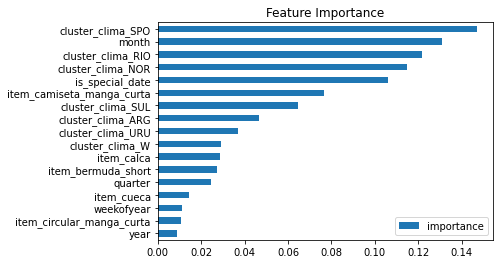

In [137]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Grid Serch para procurar os melhores parâmetros. 

**NÃO EXECUTAR O GRID SEARCH!!!!**

DEMORA EM MÉDIA 2HORAS

In [123]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1000, 2000, 300],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'booster': ['gbtree', 'gblinear'] 
}

In [146]:
model = xgb.XGBRegressor()

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_absolute_percentage_error', cv=tscv)

grid_search.fit(treino.drop(columns='venda'), treino['venda'])

# Get the best hyperparameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)
print(best_estimator)

Best Hyperparameters:
{'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 1000}
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
